In [1]:
import datetime
import os
import sys
import time

from torch.optim import Optimizer
from torch.utils.data import DataLoader

from inference import infer, evaluate
from metrics import Metrics

# Hack for module imports
module_path = os.path.abspath(os.path.join('../data'))
if module_path not in sys.path:
    sys.path.append(module_path)

from loaders import FlatsDatasetLoader

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

from plots import plot_metrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Will operate on device {device}')

Will operate on device cuda


In [3]:
image_size = 64

data_loader = FlatsDatasetLoader(
    images_dir='../data/images',
    resize_to=image_size,
    device=device,
    batch_size=400
)
data_loader.load(verbose=True)
train_loader = data_loader.get_train_loader()
test_loader = data_loader.get_test_loader()
classes_count = data_loader.get_classes_count()

Loading dataset from files...
Broken file: ..\data\images\train\Industrial\646.jpg
Done. Creating PyTorch datasets...
Done.


In [4]:
def train(
        model: nn.Module,
        train_data: DataLoader,
        test_data: DataLoader,
        optimizer_fn: Optimizer,
        loss_fn,
        epochs: int
) -> [Metrics, Metrics]:
    model.train()
    test_metrics = Metrics()
    train_metrics = Metrics()
    for _ in tqdm(range(epochs), total=epochs):
        train_outs, train_losses = np.array([]), []
        ys = np.array([])
        for data in train_data:
            optimizer_fn.zero_grad()
            output, loss = infer(data, model, loss_fn, device)
            ys = np.concatenate((ys, data[1].data.numpy()))
            train_outs = np.concatenate(
                (train_outs, torch.nn.functional.softmax(output, dim=1).cpu().data.numpy().argmax(axis=1))
            )
            loss.backward()
            train_losses.append(loss.item())
            optimizer_fn.step()
        train_metrics.add_new(train_outs, ys, train_losses)
        test_trues, test_preds, test_losses = evaluate(model, test_data, loss_fn, device)
        test_metrics.add_new(test_preds, test_trues, test_losses)

    return test_metrics, train_metrics

In [5]:
def conduct_experiment(title, model, n_epochs, optimizer):
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    test_metrics, train_metrics = train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
    end = time.time()
    model_directory = os.path.join('models', title)
    path = os.path.join(model_directory, f'{datetime.datetime.now().strftime("%y-%b-%d-%H-%M")}.pt')
    try:
        os.mkdir(model_directory)
    except FileExistsError:
        pass
    torch.save(model, path)
    print(f'Model saved in {path}')
    plot_metrics(title, test_metrics, train_metrics, n_epochs, end - start, image_size, device)

In [6]:
resnet_model = torch.hub.load(
    'pytorch/vision:v0.10.0',
    'resnet18',
    num_classes=data_loader.get_classes_count()
).to(device)

Using cache found in C:\Users\komar/.cache\torch\hub\pytorch_vision_v0.10.0


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Model saved in models\ResNet18\22-Dec-12-20-16.pt


C:\Users\komar\Documents\University\flats\experiments\plots.py:67: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axis, labels=['test', 'train'], loc="lower center")


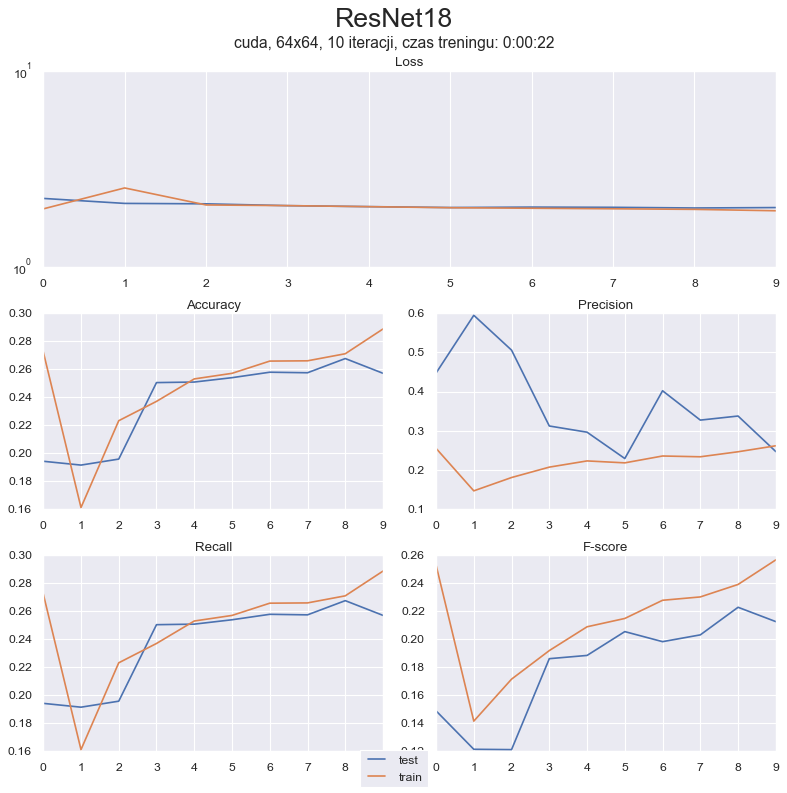

In [8]:
conduct_experiment("ResNet18", resnet_model, 10, torch.optim.Adam(resnet_model.parameters()))